# Use Real Health Record to Build ML models to Predict OSA  
This notebook builds an optimal ML model using real data. The optimization of synthetic data model will be put in `model_synthetic.ipynb`. 

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    f1_score,
    balanced_accuracy_score,
    recall_score,
    confusion_matrix
)

from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


## Load real and synth data

In [2]:
real = pd.read_csv('../data/OSA_test2.csv')
real = real.drop(columns=['centre', 'snoring', 'f_20023_0_0', 'f_20023_1_0', 'f_4282_0_0', 'f_4282_1_0', 'Date', 'f_20016_0_0', 'f_20016_1_0', "f_eid", "IID"])
real = real.drop(columns=[col for col in real.columns if '_3_0' in col])
real.dropna(inplace=True)

synth = pd.read_csv('../results/ukb_synthetic_osa.csv', index_col=0)
synth = synth.drop(columns=['centre', 'snoring'])

print(f"Real data shape: {real.shape}")
print(f"Real patient:control:\n")
print(real['OSA'].value_counts())

print(f"Synthetic data shape: {synth.shape}")
print(f"Synthetic patient:control:\n")
print(synth['OSA'].value_counts())

Real data shape: (19423, 33)
Real patient:control:

OSA
0    19280
1      143
Name: count, dtype: int64
Synthetic data shape: (40000, 33)
Synthetic patient:control:

OSA
0    20000
1    20000
Name: count, dtype: int64


Correct data type of features.

In [3]:
real = real.astype({'Male': 'category',
                  'OSA': 'category'})

synth = synth.astype({'Male': 'category',
                  'OSA': 'category'})

In [4]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19423 entries, 2 to 221264
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PC1          19423 non-null  float64 
 1   PC2          19423 non-null  float64 
 2   Male         19423 non-null  category
 3   BMI          19423 non-null  float64 
 4   Age          19423 non-null  float64 
 5   OSA          19423 non-null  category
 6   APOE_e4      19423 non-null  int64   
 7   f_25887_2_0  19423 non-null  float64 
 8   f_25886_2_0  19423 non-null  float64 
 9   f_25003_2_0  19423 non-null  float64 
 10  f_25004_2_0  19423 non-null  float64 
 11  f_25001_2_0  19423 non-null  float64 
 12  f_25002_2_0  19423 non-null  float64 
 13  f_25005_2_0  19423 non-null  float64 
 14  f_25006_2_0  19423 non-null  float64 
 15  f_25007_2_0  19423 non-null  float64 
 16  f_25008_2_0  19423 non-null  float64 
 17  f_25009_2_0  19423 non-null  float64 
 18  f_25010_2_0  19423 non-null  f

## Preprocessing pipeline

### Split train and test data

In [5]:
# split synth data
real_X = real.drop(columns=['OSA'])
real_y = real['OSA']
X_train, X_test, y_train, y_test = train_test_split(real_X, real_y, test_size=0.2, random_state=42, stratify=real_y)

### Define preprocessing pipeline

In [6]:
numeric_features = real_X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = real_X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
X_transformed = preprocess.fit_transform(real_X)
print(X_transformed.shape)

(19423, 32)


### Reduce dimension by PCA  
This PCA is different from "PC1" and "PC2" in the read dataset, which were calculated from genome-wide SNP data.

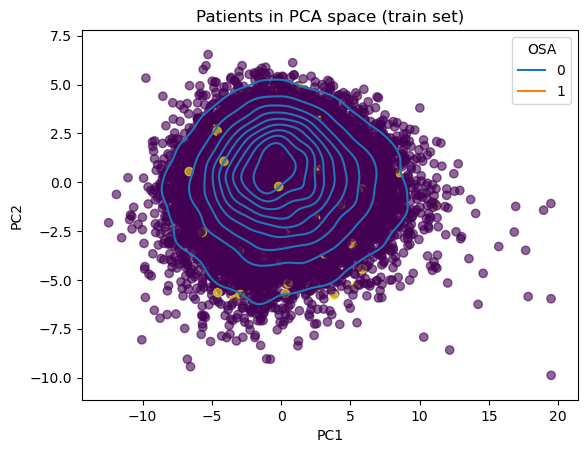

In [7]:
pca_2d = PCA(n_components=2, random_state=42)
pca = pca_2d.fit_transform(X_transformed)

# Visualization: patients in 2D PCA, colored by readmission
plt.figure()
plt.scatter(pca[:, 0], pca[:, 1], c=real_y, alpha=0.6)
sns.kdeplot(x=pca[:, 0], y=pca[:, 1], hue=real_y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patients in PCA space (train set)")
plt.show()

## Feature selection

In [8]:
# 1) L1-logistic as selector
l1_selector_est = LogisticRegression(
    penalty="l1",
    solver="saga",
    class_weight="balanced",
    max_iter=1000
)

selector = SelectFromModel(
    estimator=l1_selector_est,
    max_features=X_transformed.shape[1],
    threshold="median"
)

# 2) Pipeline: preprocess -> L1 selector
fs_pipe = Pipeline(steps=[
    ("preprocess", preprocess),  
    ("select", selector)
])

# Fit on TRAIN ONLY
fs_pipe.fit(X_train, y_train)

# 3) Get transformed feature names and support mask
preprocess_fitted = fs_pipe.named_steps["preprocess"]
selector_fitted   = fs_pipe.named_steps["select"]

all_feature_names = preprocess_fitted.get_feature_names_out()
support_mask      = selector_fitted.get_support()

selected_feature_names = all_feature_names[support_mask]

print("Number of selected features:", len(selected_feature_names))
for f in selected_feature_names:
    print(f)

Number of selected features: 16
num__BMI
num__f_25003_2_0
num__f_25004_2_0
num__f_25001_2_0
num__f_25002_2_0
num__f_25005_2_0
num__f_25006_2_0
num__f_25007_2_0
num__f_25008_2_0
num__f_25009_2_0
num__f_25010_2_0
num__f_25011_2_0
num__f_25020_2_0
num__f_25014_2_0
num__f_25013_2_0
cat__Male_1


## Model selection
### Lasso Regression

In [9]:
pipe_logreg_fs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        class_weight="balanced",
        max_iter=1000
    ))
])

### Random Forest modeling pipe

In [10]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=42
    ))
])


### XGBoost modeling pipe


In [11]:
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ('fs', selector),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


### K-nearst Neighbors


In [12]:
pipe_knn = Pipeline(steps=[
    ("preprocess", preprocess),
    ('fs', selector),
    ("clf", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance"
    ))
])


### Gaussian Naive Bayes


In [13]:
pipe_nb = Pipeline(steps=[
    ("preprocess", preprocess),
    ('fs', selector),
    ("clf", GaussianNB())
])


## Tune parameters by GridSearchCV  
Define parameter spaces to search for.

In [14]:
param_grid_logreg = {
    "clf__C": [0.05, 0.1, 1.0]
}


param_grid_rf = {
    "clf__n_estimators": [400, 800, 1200],
    "clf__max_depth": [5, 10, 20]
}


param_grid_xgb = {
    "clf__n_estimators": [200, 400, 800],
    "clf__max_depth": [3, 5, 10],
    "clf__learning_rate": [0.01, 0.05, 0.1]
}


param_grid_knn = {
    "clf__n_neighbors": [10, 50, 100]
}


param_grid_nb = {
    # "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
}


In [15]:
def run_gridsearch(pipe, param_grid, X_train, y_train, scoring="roc_auc", cv=5):
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}, Best {scoring} score: {grid.best_score_}")
    return grid

Find the best model and its optimal parameters.


In [16]:
print("\nOptimizing logistic regresion:")
grid_logreg = run_gridsearch(pipe_logreg_fs, param_grid_logreg, X_train, y_train)

print("\nOptimizing random forest:")
grid_rf = run_gridsearch(pipe_rf, param_grid_rf, X_train, y_train)

print("\nOptimizing XGBoost:")
grid_xgb = run_gridsearch(pipe_xgb, param_grid_xgb, X_train, y_train)

print("\nOptimizing K-nearest neighbor:")
grid_knn = run_gridsearch(pipe_knn, param_grid_knn, X_train, y_train)

print("\nOptimizing Naive Bayes:")
grid_nb = run_gridsearch(pipe_nb, param_grid_nb, X_train, y_train)


Optimizing logistic regresion:


Best params: {'clf__C': 0.05}, Best roc_auc score: 0.7766756897250109

Optimizing random forest:


/home/peng/anaconda3/envs/info511/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/peng/anaconda3/envs/info511/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/peng/anaconda3/envs/info511/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/peng/anaconda3/envs/info511/lib/py

Best params: {'clf__max_depth': 20, 'clf__n_estimators': 1200}, Best roc_auc score: 0.7785513853559392

Optimizing XGBoost:
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200}, Best roc_auc score: 0.8052902466676789

Optimizing K-nearest neighbor:
Best params: {'clf__n_neighbors': 100}, Best roc_auc score: 0.6949011803700106

Optimizing Naive Bayes:
Best params: {}, Best roc_auc score: 0.7612875606635037


## Train the final model  
I will select the best model as shown in the above to build the ML model. Currently, the best model is a XGBoost model with learning_rate=0.01, n_estimators=200 and max_depth=3.

In [17]:
final_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("fs", selector),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate = 0.01,
        n_estimators=200,
        max_depth=3,
        n_jobs=-1,
        random_state=42
    ))
])

### Fit final model using train data and predict the test data

In [18]:
final_model.fit(X_train, y_train)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

### Evaluate performance on test set

In [19]:
roc  = roc_auc_score(y_test, y_test_proba)
acc  = accuracy_score(y_test, y_test_pred)
f1   = f1_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec  = recall_score(y_test, y_test_pred)
cm   = confusion_matrix(y_test, y_test_pred)

print("=== Final ML model on TEST set ===")
print(f"ROC-AUC:  {roc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"Precision:{prec:.3f}")
print(f"Recall:   {rec:.3f}")
print("Confusion matrix:\n", cm)

=== Final ML model on TEST set ===
ROC-AUC:  0.856
Accuracy: 0.993
F1:       0.000
Precision:0.000
Recall:   0.000
Confusion matrix:
 [[3856    0]
 [  29    0]]


In [20]:
import joblib
joblib.dump(final_model, filename='../results/real_model.pkl')
joblib.dump(X_test, '../results/real_X_test.pkl')
joblib.dump(y_test, '../results/real_y_test.pkl')

['../results/real_y_test.pkl']

## Synthetic and realworld "cross" validation  
I will show the performance of each model in predicting the other party's test set. The aim is to reveal which one is more generalizable.  
The following loads the saved synthetic test set and model. 

In [21]:
synthetic_X_test = joblib.load('../results/synthetic_X_test.pkl')
synthetic_y_test = joblib.load('../results/synthetic_y_test.pkl')
synthetic_final_model = joblib.load('../results/synthetic_model.pkl')

### Use real model to predict synthetic data  
This is the usecase of synthetic data in evaluating the generalizablity of a model.

In [22]:
realmodel_synthdata_y_test_proba = final_model.predict_proba(synthetic_X_test)[:, 1]
realmodel_synthdata_y_test_pred = (realmodel_synthdata_y_test_proba >= 0.5).astype(int)

roc  = roc_auc_score(synthetic_y_test, realmodel_synthdata_y_test_proba)
acc  = accuracy_score(synthetic_y_test, realmodel_synthdata_y_test_pred)
f1   = f1_score(synthetic_y_test, realmodel_synthdata_y_test_pred)
prec = precision_score(synthetic_y_test, realmodel_synthdata_y_test_pred)
rec  = recall_score(synthetic_y_test, realmodel_synthdata_y_test_pred)
cm   = confusion_matrix(synthetic_y_test, realmodel_synthdata_y_test_pred)

print("=== REAL ML model on SYNTHETIC test set ===")
print(f"ROC-AUC:  {roc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"Precision:{prec:.3f}")
print(f"Recall:   {rec:.3f}")
print("Confusion matrix:\n", cm)

=== REAL ML model on SYNTHETIC test set ===
ROC-AUC:  0.799
Accuracy: 0.500
F1:       0.000
Precision:0.000
Recall:   0.000
Confusion matrix:
 [[4000    0]
 [4000    0]]


### Use synthetic model to predict real data  
This is the usecase where synthetic data is used to build a model to apply to real world data.

In [23]:
synthmodel_realdata_y_test_proba = synthetic_final_model.predict_proba(X_test)[:, 1]
synthmodel_realdata_y_test_pred = (synthmodel_realdata_y_test_proba >= 0.5).astype(int)

roc  = roc_auc_score(y_test, synthmodel_realdata_y_test_proba)
acc  = accuracy_score(y_test, synthmodel_realdata_y_test_pred)
f1   = f1_score(y_test, synthmodel_realdata_y_test_pred)
prec = precision_score(y_test, synthmodel_realdata_y_test_pred)
rec  = recall_score(y_test, synthmodel_realdata_y_test_pred)
cm   = confusion_matrix(y_test, synthmodel_realdata_y_test_pred)

print("=== SYNTHETIC ML model on REAL test set ===")
print(f"ROC-AUC:  {roc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"Precision:{prec:.3f}")
print(f"Recall:   {rec:.3f}")
print("Confusion matrix:\n", cm)

=== SYNTHETIC ML model on REAL test set ===
ROC-AUC:  0.851
Accuracy: 0.769
F1:       0.049
Precision:0.025
Recall:   0.793
Confusion matrix:
 [[2964  892]
 [   6   23]]
